In [1]:
# -- LOG -- #
import logging as log
log.basicConfig(filename='./Logs/inception.log',
                filemode='w',
                format='[%(asctime)s]:[%(name)s]:(%(levelname)s): %(message)s',
                level=log.INFO)

In [2]:
# -- IMPORTS -- #
try:
    from keras.applications.inception_v3 import InceptionV3
    from keras.models import Model
    from keras.layers import Dense
    from keras.preprocessing import image as kerasImage
    from PIL import Image as pilImage
    from scipy.ndimage.filters import gaussian_filter, median_filter
    %matplotlib inline
    import matplotlib.pyplot as plt
    import keras.backend as K
    import imageio
    import subprocess
    import numpy as np
    import os
except Exception as e:
    log.error('Failed -- IMPORT:\n',exc_info=True)
    raise SystemExit(0)

Using TensorFlow backend.


In [3]:
# -- DEFINE MODEL -- #
model = InceptionV3(weights='imagenet',include_top=True)
weights = model.layers[-1].get_weights()
model.layers.pop()
model.layers[-1].outbound_nodes = []
model.outputs = [model.layers[-1].output]
output = Dense(1000,activation='linear')(model.outputs[0])
inceptionModel = Model(inputs=model.inputs,outputs=[output])
inceptionModel.layers[-1].set_weights(weights)
imgInput = inceptionModel.inputs[0]
prediction = inceptionModel.outputs[0]
for layer in inceptionModel.layers:
    layer.trainable = False

In [6]:
# -- DEFINE FUNCTIONS -- #
def deprocess_image(x):    
    x -= x.mean(); x /= (x.std() + K.epsilon()); x*= 0.25
    # CLIP DATA
    x += 0.5; x = np.clip(x, 0, 1)
    # CONVERT TO RGB
    x *= 255; x = np.clip(x, 0, 255).astype('uint8')
    return x

In [4]:
### -- ACTIVATION MAXIMIZATION FOR ONE FILTER OF A SPECIFIC LAYER -- #
if not os.path.isdir('./Results/Inception'):
    os.mkdir('./Results/Inception')
    log.info('Directory created.')
    
# -- DEFINE HYPERPARAMETERS -- #
size = inceptionModel.input_shape[1:][0]
learningRate = 12000
l2Decay = 0.0
medianFilterSize = 3
medianFilterEvery = 12
earlyStop = 0
blurStd = 0.12
blurEvery = 20

# -- NESTEROV HYPERPARAMETERS -- #
momentum = 0.9
velocity = np.zeros(inceptionModel.input_shape[1:])

# -- RMSPROP HYPERPARAMETERS -- #
decayRate = 0.9
cache = np.zeros(inceptionModel.input_shape[1:])

# -- ADAM HYPERPARAMETERS -- #
beta1 = 0.9
beta2 = 0.999
m = np.zeros(inceptionModel.input_shape[1:])
v = np.zeros(inceptionModel.input_shape[1:])

# -- SELECT CLASS TO MAXIMIZE -- #
epochs = int(input('Select the number of iterations:'))
selClass = int(input('Select the class you want to maximize (0-{0})'.format(prediction.get_shape()[1]-1)))
option = int(input('Select the Method of gradient: Classic(0), Nesterov(1), RMSProp(2), Adam(3)'))
gifImg = []

# -- DEFINE LOSS & GRADIENT -- #
loss = prediction[0,selClass]
grads = K.gradients(loss,imgInput)[0]
iterate = K.function([imgInput],[loss,grads])

Select the number of iterations: 800
Select the class you want to maximize (0-999) 309
Select the Method of gradient: Classic(0), Nesterov(1), RMSProp(2), Adam(3) 1


In [5]:
# -- START ITERATION -- #
imgInputData = np.random.normal(0,10,(1,size,size,3))
log.info('Starting Iterations')
gifImg.append(imgInputData[0].copy())
for k in range(epochs):
    if option == 0:
        lossVal,gradVal = iterate([imgInputData])
        imgInputData += gradVal*learningRate
    elif option == 1:
        lossVal,gradVal = iterate([imgInputData+momentum*velocity])
        velocity = momentum*velocity+learningRate*gradVal
        imgInputData += velocity
    elif option == 2:
        lossVal, gradVal = iterate([imgInputData])
        cache = decayRate*cache+(1-decayRate)*np.square(gradVal)
        imgInputData += learningRate * gradVal / (np.sqrt(cache) + K.epsilon())
    elif option == 3:
        lossVal, gradVal = iterate([imgInputData])
        m = beta1 * m + (1-beta1) * gradVal
        v = beta2 * v + (1-beta2) * np.square(gradVal)
        imgInputData += learningRate * m / (np.sqrt(v) + K.epsilon())
    else:
        log.error('Option introduced not supported.')
        break
    # -- EARLY STOPPING -- #
    log.info('Current loss value:'+str(lossVal))
    if earlyStop is not 0 and lossVal >= earlyStop:
        log.info('Early Stopping achieved on epoch: '+str(k))
        break
    # -- CLIPPING -- #
    imgInputData = np.clip(imgInputData,0,255).astype('float32')
    # -- REGULARIZATION -- #
    if k != epochs-1:
        if l2Decay > 0:
            imgInputData *= (1-l2Decay)
        if blurStd is not 0 and k % blurEvery == 0:
            imgInputData = gaussian_filter(imgInputData, sigma=[0, blurStd, blurStd, 0])
        if medianFilterSize is not 0 and k % medianFilterEvery == 0 :
            imgInputData = median_filter(imgInputData, size=(1, medianFilterSize, medianFilterSize, 1))
    gifImg.append(imgInputData[0].copy())

NameError: name 'deprocess_image' is not defined

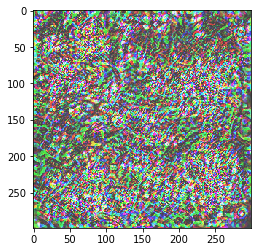

In [7]:
# -- SAVE RESULTS -- #
img = deprocess_image(imgInputData[0])
log.info('Saving Final Image. Size:'+str(img.shape))
plt.imshow(img)
plt.show()
img = kerasImage.array_to_img(img,scale=False)
img.save('./Results/Inception/Class_'+str(selClass)+'.png')